To install the required packages check it #requirement.txt


In [ ]:
from google.colab import files
uploaded = files.upload()  # then choose your local requirements.txt file


Saving requirements.txt to requirements.txt


installing the packages.

In [ ]:
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━


# **importing the necessary modules**
> Add blockquote



In [ ]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile

backend = Aer.get_backend('qasm_simulator')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from qiskit import QuantumCircuit, Aer, transpile


QUANTUM CFD

In [ ]:
N = 16
num_qubits = N * N                                               # Total number of qubits: one per grid cell
shots = 4096
def circular_mask(N):                                            # we Define a function for circular obstacle mask on the grid
    center = N // 2                                              # this is  center of the grid
    y, x = np.ogrid[:N, :N]                                      # here we create a 2D grid coordinates
    return (x - center)**2 + (y - center)**2 <= (N // 4)**2

obstacle_mask = circular_mask(N)                                 # we  create a  circular obstacle mask
fluid_mask = ~obstacle_mask                                      # The Fluid region is everywhere else

#Inject fluid at the left boundary (we start from here)

source_col = 1                                                   # Source location: left boundary column (column index = 1), multiple rows:source_rows = [1,2,3,4,5]
source_rows = [1,2,3,4,5]

qc = QuantumCircuit(num_qubits, num_qubits)                       # we Create quantum circuit with num_qubits qubits and classical bits
for row in source_rows:
    idx = row * N + source_col                                   # Convert 2D position to 1D index
    if fluid_mask[row, source_col]:                              # Only apply if it's not part of the obstacle
        qc.h(idx)                                                # Apply Hadamard gate to source qubits to initialize fluid superposition if above conditionis true.

# Defining a function to get 4-connected neighbors (up, down, left, right)

def get_neighbors(i, j, N):
    for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
        ni, nj = i + dx, j + dy
        if 0 <= ni < N and 0 <= nj < N:
            yield ni, nj

#Apply entanglement between neighboring fluid cells using CNOT gates ,if all conditions are true

for i in range(N):
    for j in range(N):
        if not fluid_mask[i, j]:                                # this will Skip obstacle cells
            continue
        idx = i * N + j
        for ni, nj in get_neighbors(i, j, N):
            if fluid_mask[ni, nj]:
                nidx = ni * N + nj
                qc.cx(idx, nidx)                               # Only entangle with other fluid cells

#Apply directional rotation (RY) to represent directional fluid velocity

for i in range(num_qubits):
    if fluid_mask[i // N, i % N]:                              # Again, here skip  obstacles
        qc.ry(np.pi / 6, i)                                    # Apply RY rotation for flow dynamics

qc.measure(range(num_qubits), range(num_qubits))               # Mapping qubit results to classical bits


In [ ]:
#after Importing the Qiskit Aer backend for simulation
backend = Aer.get_backend('qasm_simulator')                                      #we Get the quantum assembly simulator (QASM) to simulate quantum measurements
t_qc = transpile(qc, backend)                                                     #we Transpile the quantum circuit for the selected backend
result = backend.run(t_qc, shots=shots).result()                                 # Run the transpiled quantum circuit on the simulator for the given number of shots
counts = result.get_counts()                                                      # here we extract the measurement results (bitstrings and how many times they occurred)

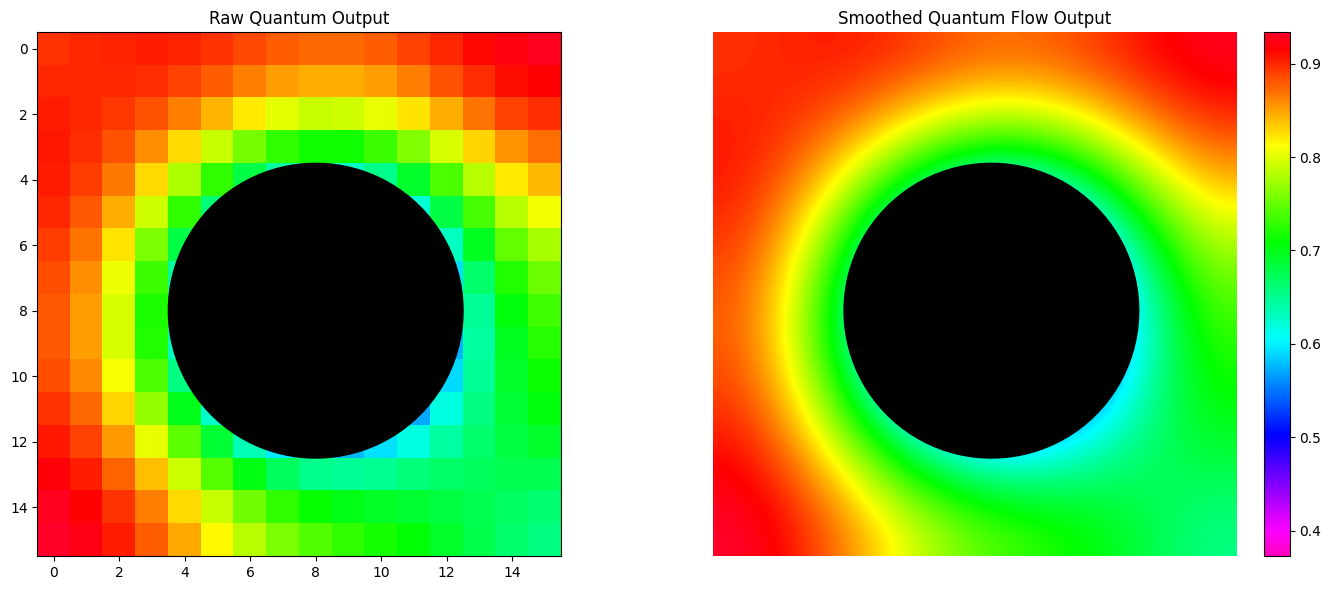

In [ ]:
 grid_vals = np.zeros((N, N))                                                   # here we Create an empty 2D array to accumulate the fluid presence probabilities

for outcome, freq in counts.items():                                            #we set a Loop through all measured bitstring outcomes and their frequencies
    for q in range(num_qubits):                                                 # For each qubit in the circuit
        i, j = q // N, q % N                                                    # Converting flat qubit index to 2D grid coordinates

        if fluid_mask[i, j] and outcome[::-1][q] == '1':                        # Only process if it's a valid fluid cell and the measured bit is '1'
            grid_vals[i, j] += freq                                             # Accumulating count in the grid cell

grid_vals = grid_vals / np.max(grid_vals[fluid_mask])                           # Normalizing the grid values so the maximum is 1 (makes colors consistent)

smoothed = gaussian_filter(grid_vals, sigma=3)                                  # Appling Gaussian smoothing to the grid to make the visualization less noisy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))                                  # Creating side by side plots to compare raw and smoothed results


im = axs[0].imshow(smoothed, cmap='gist_rainbow_r', interpolation='nearest')    # we would show the raw output as a 2D image using a rainbow colormap


theta = np.linspace(0, 2 * np.pi, 100)                                          # we draw a black circle to represent the obstacle in the flow
r = (N // 4) + 0.5                                                              #note: Radius slightly larger than obstacle mask
cx = cy = N // 2
x = cx + r * np.cos(theta)
y = cy + r * np.sin(theta)
axs[0].fill(x, y, color='black')
axs[0].set_title('Raw Quantum Output')

# Second plot: smoother visualization with better interpolation

im2 = axs[1].imshow(smoothed, cmap='gist_rainbow_r', interpolation='bicubic')
axs[1].set_title('Smoothed Quantum Flow Output')
axs[1].axis('off')                                                               # we hide axes for cleaner look
axs[1].fill(x, y, color='black')                                                # we add obstacle again

fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)                          # we add a colorbar to the second subplot for intensity reference

plt.axis('off')                                                                 # we hide axes for cleaner look
plt.tight_layout()

plt.savefig("quantum_fluid_sim.png", dpi=300)                                   #we save the final figure to a high-resolution image file
plt.show()


downloading the result as PNG

In [ ]:
from google.colab import files
files.download("quantum_fluid_sim.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Classical CFD


importing the neccessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

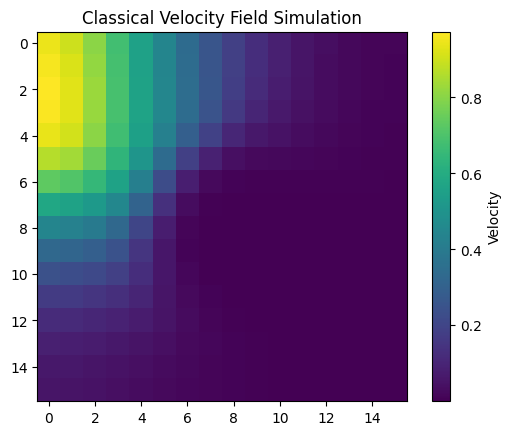

In [ ]:
N = 16
def circular_mask(N):                                                           # Function is  to create a circular obstacle mask
    center = N // 2                                                             # Center of the grid
    y, x = np.ogrid[:N, :N]                                                     # Create 2D grid coordinates
    return (x - center)**2 + (y - center)**2 <= (N // 4)**2

obstacle_mask = circular_mask(N)                                                 # Mask representing obstacle area
fluid_mask = ~obstacle_mask                                                      # Inverse of obstacle; where the fluid can flow

velocity = np.zeros((N, N))                                                      # Initialize velocity grid with zeros

source_col = 1                                                                   # Column where fluid is injected
source_rows = [1, 2, 3, 4, 5]                                                    # Rows for fluid source

for row in source_rows:                                                          # Initialize source velocities to 1.0
    velocity[row, source_col] = 1.0

for _ in range(50):                                                              # Run simulation for 50 time steps
    velocity_new = velocity.copy()                                               # Copy to update grid synchronously
    for i in range(N):                                                           # Loop through grid rows
        for j in range(N):                                                       # Loop through grid columns
            if fluid_mask[i, j]:                                                 # Only update fluid cells
                neighbors = []                                                   # To collect neighbor velocities  i.e 4-neighbour directions
                for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                    ni, nj = i + di, j + dj                                      # Neighbour coordinates
                    if 0 <= ni < N and 0 <= nj < N and fluid_mask[ni, nj]:       # Validating fluid neighbour
                        neighbors.append(velocity[ni, nj])
                if neighbors:                                                    # If there are neighbours
                    velocity_new[i, j] = np.mean(neighbors)                      # Update with average velocity
    velocity = velocity_new                                                      # Update velocity grid

    for row in source_rows:                                                      # Reinforce the source velocities
        velocity[row, source_col] = 1.0                                          # Maintain fixed source input

velocity = gaussian_filter(velocity, sigma=1)                                    # Smooth the field for better visualization

plt.imshow(velocity, cmap='viridis')                                             # Plot velocity field as heatmap
plt.title("Classical Velocity Field Simulation")                                 # Title of the plot
plt.colorbar(label='Velocity')                                                   # Colorbar indicating velocity magnitude
plt.show()                                                                       # Display the plot


In [ ]:
center_row = N // 2
classical_line = velocity[center_row, :]  # Real classical velocity


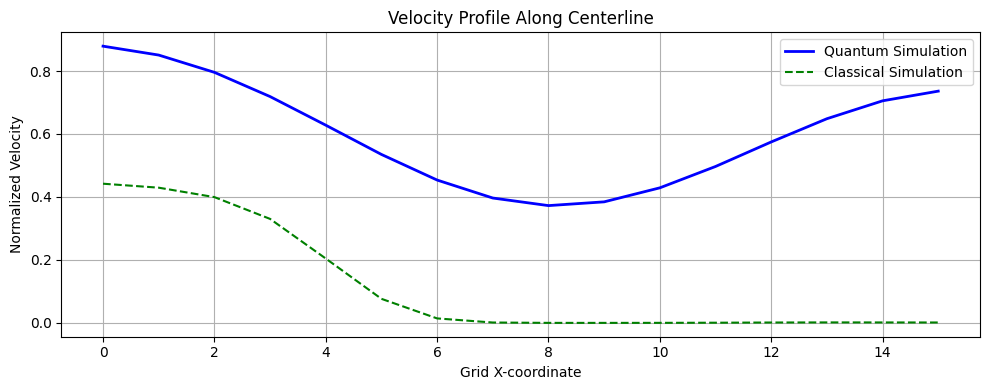

In [ ]:
# center_row must be same for both
center_row = N // 2
quantum_line = smoothed[center_row, :]         # for quantum
classical_line = velocity[center_row, :]       # fro classical

x_vals = np.arange(N)

plt.figure(figsize=(10, 4))
plt.plot(x_vals, quantum_line, label='Quantum Simulation', linewidth=2, color='blue')
plt.plot(x_vals, classical_line, label='Classical Simulation', linestyle='--', color='green')
plt.title('Velocity Profile Along Centerline')
plt.xlabel('Grid X-coordinate')
plt.ylabel('Normalized Velocity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('centerline_velocity_comparison1.png', dpi=300)
plt.show()
